## パッケージ導入

In [ ]:
!pip install --upgrade google-cloud-aiplatform japanize_matplotlib

In [2]:
import IPython
app = IPython.Application.instance()
_ = app.kernel.do_shutdown(True)

## 事前準備

In [1]:
import os, json, datetime, pprint
import numpy as np

from IPython.display import Image, display, HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import japanize_matplotlib

import vertexai
import vertexai.preview.generative_models as generative_models
from vertexai.preview.generative_models import GenerativeModel, Part
from vertexai.preview import caching

In [2]:
PROJECT_ID = !gcloud config get-value project
PROJECT_ID = PROJECT_ID[-1]
vertexai.init(project=PROJECT_ID, location='us-central1')

BUCKET = f'gs://{PROJECT_ID}-handson'

model_flash = GenerativeModel('gemini-1.5-flash')

In [3]:
def create_cached_model(movie_file, model_name='gemini-1.5-pro-001', ttl=60):
    prompt_cached = [
        '[movie file]',
        Part.from_uri(movie_file, mime_type='video/mp4'),
    ]
    cached_content = caching.CachedContent.create(
        model_name=model_name,
        contents=prompt_cached,
        ttl=datetime.timedelta(minutes=ttl)
    )
    model = GenerativeModel.from_cached_content(cached_content=cached_content)
    return model

In [4]:
def generate(prompt, model, temperature=0.4, top_p=0.4):
    responses = model.generate_content(
        prompt,
        generation_config={
            'max_output_tokens': 8192,
            'temperature': temperature,
            'top_p': top_p
        },
        safety_settings={
            generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        },
        stream=True,
    )

    result = ''
    for response in responses:  # API からの応答をストリーミングで画面表示
        try:
            print(response.text, end='')
            result += response.text
        except Exception as e:
            print(e)
            break

    return result               # 応答全体を返却

In [5]:
def load_json(text):
    text = text.replace('```json', '').replace('```', '').replace('\n', ' ')
    return json.loads(text)

## 対象動画をキャッシング

In [6]:
!gsutil ls -l {BUCKET}/mp4/s*

  24857097  2025-01-10T04:28:47Z  gs://etsuji-movie-meta-handson/mp4/s_Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -.mp4
   5514908  2025-01-10T04:28:45Z  gs://etsuji-movie-meta-handson/mp4/s_千葉県印西市にデータセンターを開設.mp4
  30815449  2025-01-10T04:28:48Z  gs://etsuji-movie-meta-handson/mp4/s_大規模言語モデルを支える分散学習インフラ Pathways.mp4
TOTAL: 3 objects, 61187454 bytes (58.35 MiB)


In [7]:
target_s = f'{BUCKET}/mp4/s_大規模言語モデルを支える分散学習インフラ Pathways.mp4'
model = create_cached_model(target_s, ttl=300)

# ファイル名の先頭が n_ の無音動画ファイルを指定すること
target_n = f'{BUCKET}/mp4/n_大規模言語モデルを支える分散学習インフラ Pathways.mp4'
model_noaudio = create_cached_model(target_n, ttl=300)

**注意**

次のコマンドを実行するとプロジェクト内でキャッシュ中のデータをすべて削除できます。

キャッシュ中のデータに対する不要な課金を避けるために、検証が完了したら実行しておくことをお勧めします。

```
for item in caching.CachedContent.list():
    cached_content = caching.CachedContent(
        f'projects/{item.project}/locations/{item.location}/cachedContents/{item.name}')
    cached_content.delete()
```

In [8]:
filename = target_s.split('/')[-1]
basename = filename.rstrip('.mp4').lstrip('s_')
image_dir = f'{BUCKET}/image/{basename}'
gsutil_opt = '-o GSUtil:parallel_composite_upload_threshold=150M'
local_image_dir = basename

In [ ]:
# 静止画像ファイルをローカルにコピー
!gsutil -m {gsutil_opt} cp -r "{image_dir}" ./

## キャラクター抽出

In [10]:
prompt_identify_characters = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Find characters in the movie and describe the visual appearance of each character as detailed as possible.
B. Identify the name of each character you found on task A. If you cannot identify the name, name it "Unknown".
C. Identify representative scenes for each character where the character visually appears on the screen.

[condition]
B. The description has more than three sentences.
C. The number of scenes for each character is at most three. Each scene is identified with timestamp mm:ss-mm:ss.

[format instruction]
In Japanese. Output is a JSON list of "character dict". "character dict" is a JSON dict in the following format:
{
  "Character ID": <Sequential number starting from 1>,
  "Name": "<Character name>",
  "Visual Description": "<Visual appearance>",
  "Scenes": [ "<list of timestamp of representative scenes>" ]
}
'''

In [11]:
result = generate(prompt_identify_characters, model=model)

[
  {
    "Character ID": 1,
    "Name": "中井悦司",
    "Visual Description": "中井悦司さんは黒のポロシャツを着て、眼鏡をかけています。髪は短く、黒髪です。肌の色は中間色で、年齢は40代から50代くらいに見えます。彼はプレゼンテーションを行っており、落ち着いた雰囲気で話しています。",
    "Scenes": [
      "00:12-00:27",
      "00:27-01:02",
      "01:53-02:05"
    ]
  },
  {
    "Character ID": 2,
    "Name": "北瀬 公香",
    "Visual Description": "北瀬公香さんは黒のジャケットに白いTシャツを着て、眼鏡をかけています。髪は短く、黒髪です。肌の色は中間色で、年齢は30代から40代くらいに見えます。彼はプレゼンテーションの司会進行役を務めており、明るい雰囲気で話しています。",
    "Scenes": [
      "18:27-18:36",
      "18:36-18:51",
      "19:14-19:21"
    ]
  }
]

=====
1 中井悦司 中井悦司さんは黒のポロシャツを着て、眼鏡をかけています。髪は短く、黒髪です。肌の色は中間色で、年齢は40代から50代くらいに見えます。彼はプレゼンテーションを行っており、落ち着いた雰囲気で話しています。


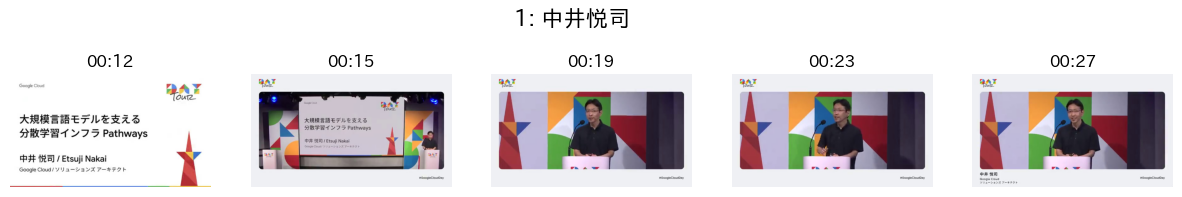

<Figure size 640x480 with 0 Axes>

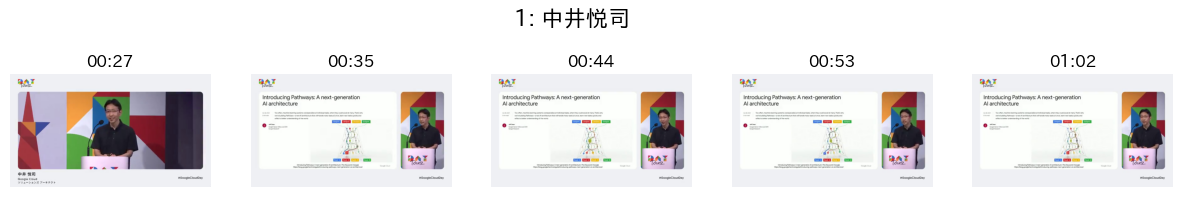

<Figure size 640x480 with 0 Axes>

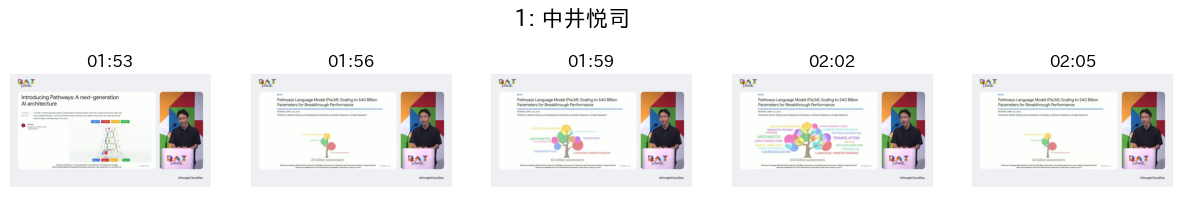

=====
2 北瀬 公香 北瀬公香さんは黒のジャケットに白いTシャツを着て、眼鏡をかけています。髪は短く、黒髪です。肌の色は中間色で、年齢は30代から40代くらいに見えます。彼はプレゼンテーションの司会進行役を務めており、明るい雰囲気で話しています。


<Figure size 640x480 with 0 Axes>

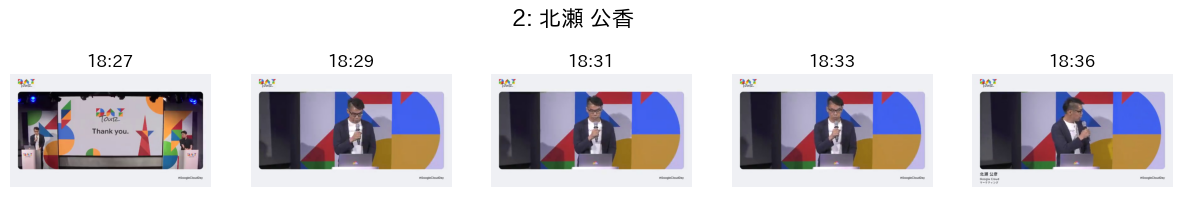

<Figure size 640x480 with 0 Axes>

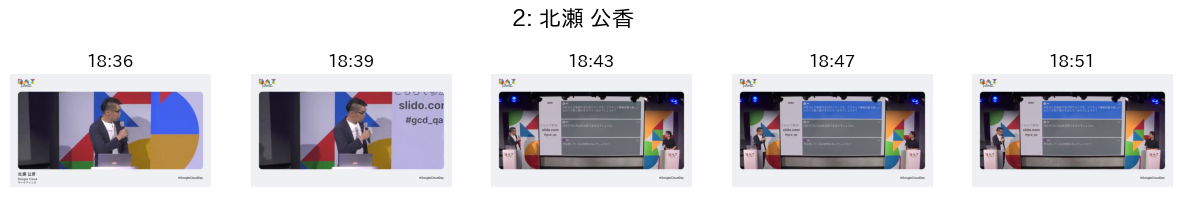

<Figure size 640x480 with 0 Axes>

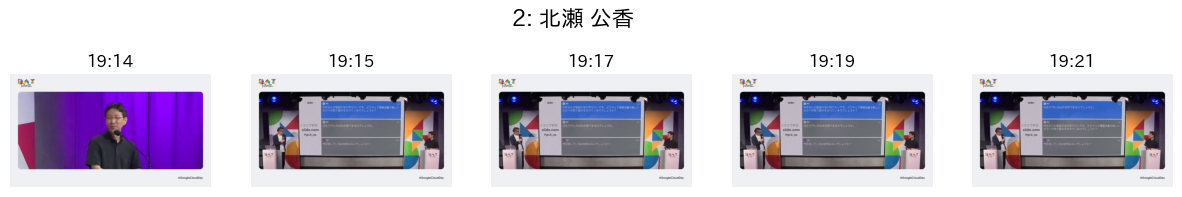

<Figure size 640x480 with 0 Axes>

In [12]:
scenes = load_json(result)
jpg_files = !ls "{local_image_dir}/"
m = 0
for c in [s.lstrip('capture').rstrip('.jpg') for s in jpg_files]:
    try:
        m = max(m, int(c))
    except:
        pass

for item in scenes:
    print('=====')
    print(item['Character ID'], item['Name'], item['Visual Description'])
    for ts in item['Scenes'][:3]:
        ts1, ts2 = ts.split('-')
        m1, s1 = ts1.split(':')
        ss1 = int(m1) * 60 + int(s1) + 1
        m2, s2 = ts2.split(':')
        ss2 = int(m2) * 60 + int(s2) + 1
        
        fig, axs = plt.subplots(1, 5, figsize=(15, 2.5))  # Adjust figsize as needed
        axs = axs.ravel()
        fig.suptitle(str(item['Character ID']) + ': ' + item['Name'], fontsize=16)
        for c, ts in enumerate(np.linspace(max(1, ss1), min(ss2, m), 5)):
            ts = int(ts)
            mm, ss = divmod(ts - 1, 60)
            image_name = f'{local_image_dir}/capture{ts:04d}.jpg'
            img = mpimg.imread(image_name)
            axs[c].imshow(img)
            axs[c].axis('off')
            axs[c].set_title(f'{mm:02d}:{ss:02d}')
        plt.show()
        plt.clf()

キャラクター名はハルシネーションが起きている可能性があるので、外見の記述と参考画像を元にネット検索で正しい名前を検索して、参照用画像ファイルを別途用意

In [13]:
chars = !gsutil ls "{image_dir}/characters/*.png"
chars

['gs://etsuji-movie-meta-handson/image/大規模言語モデルを支える分散学習インフラ Pathways/characters/中井 悦司.png',
 'gs://etsuji-movie-meta-handson/image/大規模言語モデルを支える分散学習インフラ Pathways/characters/北瀬 公彦.png']

In [14]:
prompt_reference = [
    '\n[Reference information to identify character names]'
]
image_files = {}
for item in chars:
    name = item.split('/')[-1].rstrip('.png')
    image_files[name] = item
    prompt_reference += [
        f'The name of following character is "{name}"',
        Part.from_uri(uri=image_files[name], mime_type='image/png')
    ]

prompt_reference

['\n[Reference information to identify character names]',
 'The name of following character is "中井 悦司"',
 file_data {
   mime_type: "image/png"
   file_uri: "gs://etsuji-movie-meta-handson/image/\345\244\247\350\246\217\346\250\241\350\250\200\350\252\236\343\203\242\343\203\206\343\202\231\343\203\253\343\202\222\346\224\257\343\201\210\343\202\213\345\210\206\346\225\243\345\255\246\347\277\222\343\202\244\343\203\263\343\203\225\343\203\251 Pathways/characters/\344\270\255\344\272\225 \346\202\246\345\217\270.png"
 },
 'The name of following character is "北瀬 公彦"',
 file_data {
   mime_type: "image/png"
   file_uri: "gs://etsuji-movie-meta-handson/image/\345\244\247\350\246\217\346\250\241\350\250\200\350\252\236\343\203\242\343\203\206\343\202\231\343\203\253\343\202\222\346\224\257\343\201\210\343\202\213\345\210\206\346\225\243\345\255\246\347\277\222\343\202\244\343\203\263\343\203\225\343\203\251 Pathways/characters/\345\214\227\347\200\254 \345\205\254\345\275\246.png"
 }]

## 動画サマリー

In [15]:
prompt_summary = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Give an one sentence summary of the movie that can be used as a title of the movie.
B. Summarize the content of the movie in five to ten sentences.

[condition]
A, B. If possible, identify the names of characters. Use the full name on every part of the output.
A, B. The output should be based on the objective information in the movie.

[format instruction]
In Japanese. In the JSON dict with the following format:
{
  "Title": "<Output of Task A>",
  "Summary": "<Output of Task B>"
}
'''

prompt_summary = [prompt_summary] + prompt_reference

In [16]:
result = generate(prompt_summary, model=model)

{
  "Title": "大規模言語モデルを支える分散学習インフラPathways",
  "Summary": "Google Cloudのソリューションズアーキテクトの中井悦司氏によるプレゼンテーションです。中井悦司氏は、大規模言語モデルを支える分散学習インフラ「Pathways」について解説しました。従来の機械学習モデルは、特定の形式のデータとタスクに特化していましたが、Pathwaysは、マルチモーダル・マルチタスクに対応し、様々な形式のデータを同時に処理し、複数のタスクを並列処理できるアーキテクチャを目指しています。中井悦司氏は、Pathwaysのアイデアが生まれた背景として、2012年のGoogle社内におけるディープラーニングの実用化のきっかけとなった研究成果を紹介しました。この研究では、YouTubeの動画データに非常に階層の深いニューラルネットワークを適用することで、様々な物体を認識することに成功しました。この成果をきっかけに、Google社内ではディープラーニング技術が様々なプロダクトに利用されるようになりました。また、中井悦司氏は、モデルのサイズが大きくなるほど性能が向上するという「ニューラルスケーリング則」についても解説しました。この法則を裏付ける事例として、2020年に発表された自然言語モデル「GPT-3」と、2021年にGoogleが発表した「GLAMモデル」を比較しました。GLAMモデルは、GPT-3よりもパラメータ数が多く、性能も向上しています。さらに、中井悦司氏は、複数のタイプのデータを同時に扱う「マルチモーダル」なモデルについても解説しました。例として、自然言語で文章を入力すると、その文章にマッチした画像を生成する画像生成モデルを紹介しました。また、ロボットアームに対して、テキストや動画で命令できるモデルも紹介しました。これらのモデルは、入力データの形式に合わせて個別に前処理を行い、意味を表す抽象的な潜在空間のベクトルに変換することで、様々な入力データに対して同じように処理を行うことができます。最後に、中井悦司氏は、Pathwaysに対応した巨大なモデルを学習するためのインフラとして、Googleが開発した「TPU Pod」を紹介しました。TPU Podは、多数のTPUコアをインターコネクトと呼ばれる専用線でメッシュ状に結合した

In [17]:
summary = pprint.pformat(load_json(result))

## 重要シーン抽出

In [18]:
prompt_important_scenes = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Find around 15 important scenes in the movie with accurate timestamps.
B. Give a short summary of each scene and why that scene is important.

[condition]
A, B. If possible, identify the names of characters. Use the full name on every part of the output.
The [summary] section contains the summary of the entire movie.
You don't need to use the summary information to find scenes, but the result should be consistent with the summary.

[format instruction]
In Japanese. Show only the following information.
Output in a comma separated list with two columns: <timestamp mm:ss-mm:ss>, <output of task B>
Header is: Timestamp, Description

[summary]
''' + summary

prompt_important_scenes = [prompt_important_scenes] + prompt_reference

In [19]:
important_scenes = generate(prompt_important_scenes, model=model)

Timestamp, Description
00:16-00:18, Google Cloudのソリューションズアーキテクトの中井悦司氏が自己紹介をしています。
00:21-00:26, 中井悦司氏が、これから約30分間「大規模言語モデルを支える分散学習インフラPathways」についてお話をすることを伝えています。
00:37-01:02, 中井悦司氏が、セッションのタイトルにある「Pathways」というキーワードについて説明しています。このキーワードは、2021年にGoogleの機械学習（ML）研究チームのトップであるJeff Dean氏が発表したブログ記事で初めて登場しました。
01:03-01:10, 中井悦司氏が、Jeff Dean氏のブログ記事の内容について説明しています。Jeff Dean氏は、将来の機械学習モデルのアーキテクチャとして、従来のシングルモーダル・シングルタスクのモデルから、マルチモーダル・マルチタスクのモデルへと移行していくことを提唱しています。
01:11-01:29, 中井悦司氏が、従来の機械学習モデルと、Jeff Dean氏が提唱する将来の機械学習モデルの違いについて説明しています。従来のモデルは、特定の形式のデータとタスクに特化してチューニング・開発されていましたが、将来のモデルは、様々な形式のデータを同時に取り扱って、かつ、様々なタスクを並列にこなしていくことを目指しています。
01:29-02:14, 中井悦司氏が、Jeff Dean氏が提唱する将来の機械学習モデルのアーキテクチャを体現するモデルとして、「Pathways Language Model（PaLM）」を紹介しています。PaLMは、2022年にGoogleが開発に成功した大規模自然言語モデルであり、様々なタスクをこなすことができます。
02:15-02:25, 中井悦司氏が、PaLMの性能について説明しています。PaLMは、例えば、算数の問題を解いたり、プログラム言語を出力したりすることができるなど、非常に高い性能を持っています。
02:26-02:59, 中井悦司氏が、PaLMが「Pathways Language Model」と名付けられている理由について説明しています。PaLMは、自然言語という特定の形式のデータだけを取り扱って、テキストの前半から後半

## シーン情報（ビジュアル情報）取得

In [20]:
prompt_visuals = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Split the entire movie into scenes with accurate timestamps from start to the exact end of the movie file.
B. Describe what's happening in the scene as detailed as possible.
C. Enrich the output of task B by adding visual information of not only characters but also things in the background.

[condition]
A. The length of each scene is 1 to 15 seconds.
 - Good example: 00:05-00:08, 00:05-00:18. / Bad example: 00:05-01:14 as the timestamp jumps more than 15 seconds.
B, C. Avoid using audio information to describe the scene. Describle only what you see on the screen.
B. If possible, identify the names of characters. Use the full name on every part of the output.
C. The final description is very detailed, vivid and realistic to covey all the visual information of the scene, using up to three sentences.

[format instruction]
In Japanese. Show only the following information.
Output in a comma separated list with two columns: <timestamp mm:ss-mm:ss>, <output of task C>
Header is: Timestamp, Description
'''

prompt_visuals = [prompt_visuals] + prompt_reference

In [22]:
visual_info = generate(prompt_visuals, model=model)

Timestamp, Description
00:00-00:05, 白い背景に、赤、青、黄、緑の図形が回転しながら「DAY」の文字を形作っています。中央に「Breakout Session」の文字が表示されています。
00:05-00:11, 白い背景に、赤、青、黄、緑の図形が散りばめられています。中央に日本語で「大規模言語モデルを支える分散学習インフラ Pathways」のタイトルと、その下に「中井 悦司 / Etsuji Nakai」「Google Cloud / ソリューションズ アーキテクト」と記されています。右上に赤、青、黄、緑の図形を組み合わせた「DAY Tour」のロゴ、右下に赤い星形があります。
00:11-00:15, ステージ上で中井 悦司が演台の前に立っています。背景には、赤、青、黄、緑の図形を組み合わせたデザインと「Google Cloud」「DAY Tour」のロゴが配置されています。中井 悦司は黒いポロシャツを着て、眼鏡をかけています。
00:15-00:28, 中井 悦司が演台で話しています。背景には、赤、青、黄、緑の図形を組み合わせたデザインと「Google Cloud」「DAY Tour」のロゴが配置されています。中井 悦司は黒いポロシャツを着て、眼鏡をかけています。左下に「中井 悦司」「Google Cloud / ソリューションズ アーキテクト」と記され、右下に「#GoogleCloudDay」のハッシュタグが表示されています。
00:28-00:34, 中井 悦司が演台で話しています。背景には、赤、青、黄、緑の図形を組み合わせたデザインと「DAY Tour」のロゴが配置されています。右側に中井 悦司の自己紹介スライドが表示され、写真と著書の表紙が並んでいます。
00:34-01:03, 中井 悦司が演台で話しています。背景には、赤、青、黄、緑の図形を組み合わせたデザインと「DAY Tour」のロゴが配置されています。左側に「Introducing Pathways: A next-generation AI architecture」というタイトルのブログ記事が表示され、中央には複雑な図形と「Task 1」「Task 2」などのラベルが描かれています。
01:03-01:52, 中井 悦司が演台で話しています。背景には、赤

## 音声文字起こし

In [23]:
prompt_transcription = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Transcript what they are speaking with accurate timestamps.

[condition]
A. Process the entire movie from start to the exact end of the movie file.
A. Identify the name of person who is speaking for each speech. Use the full name on every part of the output. If you cannot identify the name, name it "Unknown".

[format instruction]
In Japanese. Output is a JSON list of "speech dict". "speech dict" is a JSON dict in the following format:
{
  "timestamp": "<mm:ss-mm:ss>",
  "Name": "<Name of the speaker>",
  "Transcription": "<Transcription>"
}
'''

In [24]:
result = generate([prompt_transcription] + prompt_reference, model=model)

```json
[
  {
    "timestamp": "00:14-00:26",
    "Name": "中井 悦司",
    "Transcription": "はい 皆さん こんにちは Google Cloud ソリューションズ アーキテクト の 中井 です え 今日 私 の 方 から は こちら の タイトル で ま 約 30 分間 お 話 を さ せ て いただき ます よろしく お 願い いたし ます"
  },
  {
    "timestamp": "00:28-00:33",
    "Name": "中井 悦司",
    "Transcription": "はい で こちら いつも の 自己 紹介 スライド です ね よろしく お 願い いたし ます"
  },
  {
    "timestamp": "00:34-01:52",
    "Name": "中井 悦司",
    "Transcription": "で 早速 中身 の 方 入っ て いき たい と 思い ます が 今日 私 の セッション の タイトル の 中 に パスウェイズ と いう キーワード が あり まし た この キーワード 皆さん 聞い た こと あり ます でしょう か え 実 は パスウェイズ と いう 言葉 が 初めて 登場 し た の が こちら の ブログ 記事 な ん です ね 2021 年 2 年 前 に え Google の え 機械 学習 ML 研究 チーム の トップ です ね ジェフ ディーン が 発表 し た ブログ 記事 に なり ます で この ブログ の 中 で ジェフ ディーン は ま 今後 の 将来 の 機械 学習 モデル の アーキテクチャー を 語っ て いる ん です ね 従来 の 機械 学習 モデル と いう の は 基本 的 に は え シングル モデル シングル タスク 何 か 特定 の 形式 の データ だけ を 扱っ て 何 か 特定 の タスク 特定 の 仕事 を する ため に ま 専用 に えっと チューニング さ れ た 開発 さ れ た モデル と いう の が 基本 でし た で それ に 対し て 今後 は マルチモーダル マルチタスク いろんな 形式 の データ を 同時 に 取り扱

In [25]:
transcription = pprint.pformat(load_json(result))

## テキスト情報取得

１回の処理ですべてのテキストを取得しようとすると、出力トークン数の上限に達するので、はじめにテキストが存在するシーンの情報を取得する。

In [26]:
prompt_text_layout = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Identify scenes where text strings are on the screen.
B. Describe the layout how text strings are arranged on the screen.

[conditions]
Process the entire movie from start to the exact end of the movie file.

[format instruction]
Layout description is in Japanese.
Final output is a JSON list of "text dict". "text dict" is a JSON dict in the following format:
{
  "Timestamp": "<Timestamp mm:ss-mm:ss>",
  "Layout": "<layout description from Task B>"
}
'''

In [27]:
result = generate(prompt_text_layout, model=model_noaudio)

[
  {
    "Timestamp": "00:01-00:05",
    "Layout": "中央に文字列"
  },
  {
    "Timestamp": "00:05-00:12",
    "Layout": "左上に「Google Cloud」ロゴ、右上に「DAY Tour」ロゴ、中央にタイトル、中央下に名前、左下に所属、右下にハッシュタグ"
  },
  {
    "Timestamp": "00:23-00:29",
    "Layout": "左下に名前、左下に所属、右下にハッシュタグ"
  },
  {
    "Timestamp": "00:29-00:34",
    "Layout": "左上に「DAY Tour」ロゴ、中央に「自己紹介」、中央下に名前、左下に所属、右下にハッシュタグ"
  },
  {
    "Timestamp": "00:34-01:53",
    "Layout": "左上に「DAY Tour」ロゴ、中央にタイトル、中央下にURL、左下に名前、左下に所属、右下にハッシュタグ"
  },
  {
    "Timestamp": "01:53-03:14",
    "Layout": "左上に「DAY Tour」ロゴ、右上に「BLOG」、中央にタイトル、中央下にURL、左下に日付、左下に投稿者、右下にハッシュタグ"
  },
  {
    "Timestamp": "03:14-03:21",
    "Layout": "左上に「DAY Tour」ロゴ、中央にタイトル、右下にハッシュタグ"
  },
  {
    "Timestamp": "03:21-04:17",
    "Layout": "左上に「DAY Tour」ロゴ、中央にタイトル、中央下にURL、左下に日付、左下に投稿者、右下にハッシュタグ"
  },
  {
    "Timestamp": "04:17-04:28",
    "Layout": "左上に「DAY Tour」ロゴ、中央にタイトル、中央下にURL、右上に「Used across products:」、右下にハッシュタグ"
  },
  {
    "Timestamp": "04:28-05:13",
    "Layout": "左上に「DAY Tour

In [28]:
layout_info = load_json(result)

取得した情報から５シーンごとに分割してテキストを抽出する。

In [29]:
prompt_texts = '''\
You are a video content editor. Work on the following tasks.

[task]
A. The [text layout] contains scenes where text strings are on the screen in JSON list.
Extract exact text strings from each scene by repeating the [steps].

[steps]
1. Take the next "text dict" item from the [text layout].
2. Extract text strings from the scene specified by the "Timestamp" and "Layout".
3. Output the new "text dict" that have the "Text" element. "Timestamp" and "Layout" should be the same as the original item.

[condition]
A. Process the scenes only within the timestamps described in the [text layout]. Hence the "Timestamp" in the output should be the same as in the [text layout].
A. Output each character literally as on the screen. Don't modify them.
A. Use a list to store multiple lines of texts instead of using the return code \\n in the extracted text strings.
A. Make sure to use double quotes "" in the output JSON.

[format instruction]
Final output is a JSON list of "text dict". "text dict" is a JSON dict in the following format:
{
  "Timestamp": "<Timestamp mm:ss-mm:ss>",
  "Text": [List of text strings from Task A>],
  "Layout": "<layout description>"
}

[text layout]
'''

In [31]:
merged_result = []
for c in range(0, len(layout_info), 5):
    print(f'\n=== Scene {c+1} to {c+5} ===')
    prompt = prompt_texts + pprint.pformat(layout_info[c:c+5])
    # 正しい JSON が出力されないなどで処理エラーが発生した場合は3回リトライする。
    n = 0
    while n < 3:
        try:
            result = generate(prompt, model=model_noaudio)    
            merged_result += load_json(result)
            break
        except Exception as e:
            print(e)
            n += 1
            pass
texts = pprint.pformat(merged_result)


=== Scene 1 to 5 ===
```json
[
  {
    "Timestamp": "00:01-00:05",
    "Text": [
      "DAY",
      "Breakout",
      "Breakout Session"
    ],
    "Layout": "中央に文字列"
  },
  {
    "Timestamp": "00:05-00:12",
    "Text": [
      "大規模言語モデルを支える",
      "分散学習インフラ Pathways",
      "中井 悦司 / Etsuji Nakai",
      "Google Cloud / ソリューションズ アーキテクト",
      "#GoogleCloudDay"
    ],
    "Layout": "左上に「Google Cloud」ロゴ、右上に「DAY Tour」ロゴ、中央にタイトル、中央下に名前、左下に所属、右下にハッシュタグ"
  },
  {
    "Timestamp": "00:23-00:29",
    "Text": [
      "中井 悦司",
      "Google Cloud",
      "ソリューションズ アーキテクト",
      "#GoogleCloudDay"
    ],
    "Layout": "左下に名前、左下に所属、右下にハッシュタグ"
  },
  {
    "Timestamp": "00:29-00:34",
    "Text": [
      "自己紹介",
      "中井 悦司 / Etsuji Nakai",
      "Google Cloud / ソリューションズ アーキテクト",
      "#GoogleCloudDay"
    ],
    "Layout": "左上に「DAY Tour」ロゴ、中央に「自己紹介」、中央下に名前、左下に所属、右下にハッシュタグ"
  },
  {
    "Timestamp": "00:34-01:53",
    "Text": [
      "Introducing Pathways: A next-generation",
      "AI architect

## テキストベースの動画内検索

In [32]:
prompt_content_search = '''
You are a video content editor.

Given the following information of a movie:
- The [summary] section contains the summary of the movie.
- The [important scenes] section contains the important scenes of the movie with timestamps.
- The [visual info] section contains the visual information on what's happening in each scene with timestamps.
- The [transcription] section contains speech transcription with timestamps.
- The [text] section contains text information with timestamps.

Find one to three scenes that matches the user query with timestamps.

[format instruction]
Output in Japanese. Output is a JSON list with "scene dict".
Each "scene dict" is a JSON dict with the following format:
{{
  "Timestamp": "<timestamp mm:ss-mm:ss>",
  "Description": "<Explain how this scene matches the query.>",
  "Evidence": [<List of data snippets that support your result>]
}}

[user query]
{}

[summary]
{}

[important scenes]
{}

[visual info]
{}

[transcription]
{}

[texts]
{}
'''

In [33]:
def show_thumbnails(scenes):
    jpg_files = !ls "{local_image_dir}/"
    m = 0
    for c in [s.lstrip('capture').rstrip('.jpg') for s in jpg_files]:
        try:
            m = max(m, int(c))
        except:
            pass
    for item in scenes:
        ts = item['Timestamp']
        ts1, ts2 = ts.split('-')
        m1, s1 = ts1.split(':')
        ss1 = int(m1) * 60 + int(s1) + 1
        m2, s2 = ts2.split(':')
        ss2 = int(m2) * 60 + int(s2) + 1
        
        fig, axs = plt.subplots(1, 5, figsize=(15, 2))  # Adjust figsize as needed
        axs = axs.ravel()
        print('=====')
        print(str(item['Description']))
        for c, ts in enumerate(np.linspace(max(1, ss1-3), min(ss2+3, m), 5)):
            ts = int(ts)
            mm, ss = divmod(ts - 1, 60)
            image_name = f'{local_image_dir}/capture{ts:04d}.jpg'
            img = mpimg.imread(image_name)
            axs[c].imshow(img)
            axs[c].axis('off')
            axs[c].set_title(f'{mm:02d}:{ss:02d}')
        plt.show()
        plt.clf()

In [34]:
%%time
query = 'ニューラルスケーリングについて解説しているシーン'
prompt = prompt_content_search.format(
    query, summary, important_scenes, visual_info, transcription, texts)
result = generate(prompt, model=model_flash)

```json
[
  {
    "Timestamp": "04:25-05:12",
    "Description": "このシーンでは、中井悦司氏が、ディープラーニングのモデルサイズが大きくなるほど性能が向上するという「ニューラルスケーリング則」について解説しています。この法則は、特に自然言語モデルにおいて顕著であり、モデルのパラメータ数を増やすほど性能が向上することが経験的に知られています。",
    "Evidence": [
      "04:25-05:12, 中井悦司氏が、ディープラーニングのモデルサイズが大きくなるほど性能が向上するという「ニューラルスケーリング則」について解説しています。この法則は、特に自然言語モデルにおいて顕著であり、モデルのパラメータ数を増やすほど性能が向上することが経験的に知られています。",
      "{'Layout': '左上に「DAY Tour」ロゴ、中央にタイトル、中央下にURL、右下にハッシュタグ', 'Text': ['DAY', 'Tour', 'Neural scaling laws', '・自然言語モデル／翻訳モデルでは、モデルの規模が適切であれば、「計算', '量（モデルサイズ、データ量）」が指数関数的により大きな影響を与えるという経', '験則 (2020 / 2021年)', 'Test Loss', 'Compute', 'Dataset Size', 'Parameters', 'non-embedding', 'non-embedding', 'Figure 1. Language modeling performance improves smoothly as we increase the model size, dataset', 'size, and amount of compute used for training. For optimal performance all three factors must be scaled', 'up in tandem. Empirical performance has a power-law relationship with each individual factor when not', 'bottlenecke

=====
このシーンでは、中井悦司氏が、ディープラーニングのモデルサイズが大きくなるほど性能が向上するという「ニューラルスケーリング則」について解説しています。この法則は、特に自然言語モデルにおいて顕著であり、モデルのパラメータ数を増やすほど性能が向上することが経験的に知られています。


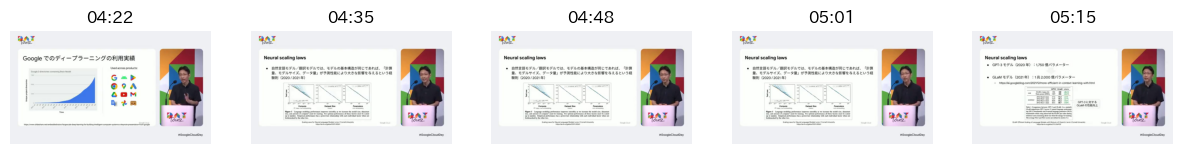

=====
このシーンでは、中井悦司氏が、「ニューラルスケーリング則」を裏付ける事例として、2020年に発表された自然言語モデル「GPT-3」と、2021年にGoogleが発表した「GLAMモデル」を比較しています。GLAMモデルは、GPT-3よりもパラメータ数が多く、性能も向上しています。このことから、モデルサイズを大きくすることで、より高い性能のモデルを開発できることが示唆されています。


<Figure size 640x480 with 0 Axes>

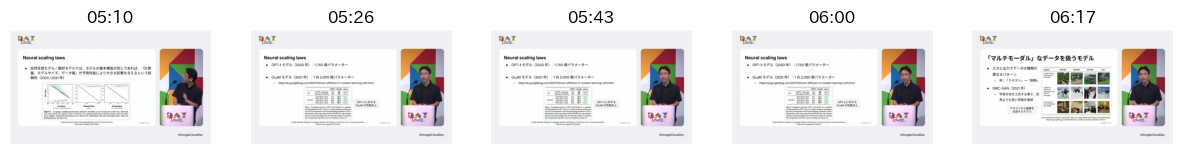

<Figure size 640x480 with 0 Axes>

In [35]:
show_thumbnails(load_json(result))

In [36]:
%%time
query = '視聴者からの質問に答えているシーン'
prompt = prompt_content_search.format(
    query, summary, important_scenes, visual_info, transcription, texts)
result = generate(prompt, model=model_flash)

```json
[
  {
    "Timestamp": "18:37-19:13",
    "Description": "このシーンでは、北瀬氏が参加者からの質問を読み上げ、中井氏がそれに答えています。質問は「中井さんの勉強方法が知りたいです。どうやって情報収集や新しいものへの取り組みをされているのでしょうか？」というもので、中井氏は「私個人に対する質問で、個人的には非常に嬉しいのですが、語り出すと30分かかってしまうので、今日はパスさせてください。是非次回のGoogle Cloud Daysで、私の勉強法のセッションを企画していただければと思います。」と答えています。",
    "Evidence": [
      {
        "Name": "北瀬 公彦",
        "Transcription": "じゃ 早速 です けど ね え 一番 上 の 質問 から 行き たい と 思い ます 中井 さん の 勉強 方法 が 知り たい です どう やっ て 情報 収集 や 新しい もの へ の 取り組み を さ れ てる の でしょう か と いう こと です けど も 中井 さん はい えっと",
        "timestamp": "18:37-18:51"
      },
      {
        "Name": "中井 悦司",
        "Transcription": "あの 私 個人 に 対する 質問 で 個人 的 に は 非常 に 嬉しい ん です けど も これ 多分 語り 出す と 30 分 かかる の で えっと 今日 は すみ ませ ん パス さ せ て ください ああ はい はい あの 是非 次回 の Google Cloud Days で あの 私 の 勉強 法 の セッション を 企画 さ せ て いただけれ ば と 思い ます あ いい です ね はい ありがとう ござい ます え",
        "timestamp": "18:52-19:11"
      }
    ]
  },
  {
    "Timestamp": "19:14-19:47",
    "Description": "このシーンでは、北瀬氏が参加者からの質問を読み上げ、中井氏がそれに答えています。質問は

=====
このシーンでは、北瀬氏が参加者からの質問を読み上げ、中井氏がそれに答えています。質問は「中井さんの勉強方法が知りたいです。どうやって情報収集や新しいものへの取り組みをされているのでしょうか？」というもので、中井氏は「私個人に対する質問で、個人的には非常に嬉しいのですが、語り出すと30分かかってしまうので、今日はパスさせてください。是非次回のGoogle Cloud Daysで、私の勉強法のセッションを企画していただければと思います。」と答えています。


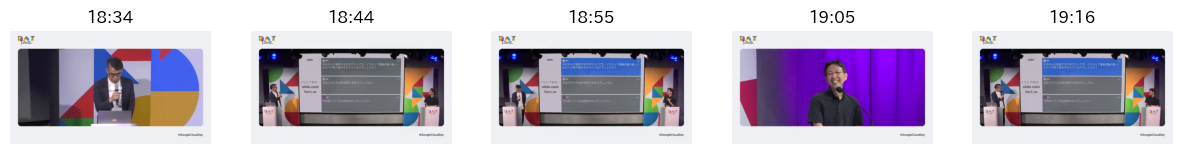

=====
このシーンでは、北瀬氏が参加者からの質問を読み上げ、中井氏がそれに答えています。質問は「GKEでTPU Podを利用できるのでしょうか？」というもので、中井氏は「現状ではTPU Podを直接GKEにアサインすることはできないと思います。別途TPU PodをGoogle Cloud上で用意して、GKEからタスクを投げることはできますが、直接のインテグレーションは、私の知る範囲ではまだないと思います。」と答えています。


<Figure size 640x480 with 0 Axes>

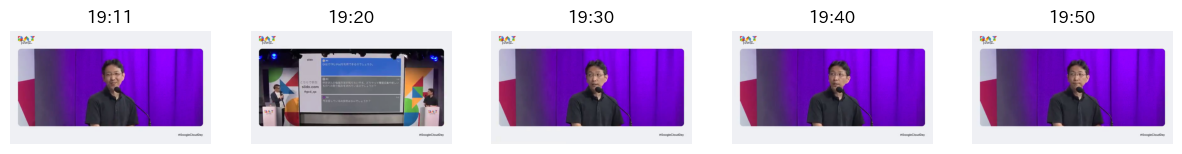

=====
このシーンでは、北瀬氏が参加者からの質問を読み上げ、中井氏がそれに答えています。質問は「現在注目しているAI技術は何か？」というもので、中井氏は「世の中の流れ的には生成AIと言うのが正解だと思いますが、私個人としては生成AIそのものよりも、生成AIをどのように実用的に使っていくかというアーキテクチャの方に興味があります。生成AI単体で使っていても、実用的なことができることは限られています。おそらく他の技術と生成AIを組み合わせる組み合わせパターンが重要になってくるので、そういった組み合わせが今後どういったものが出てくるのか注目しています。」と答えています。


<Figure size 640x480 with 0 Axes>

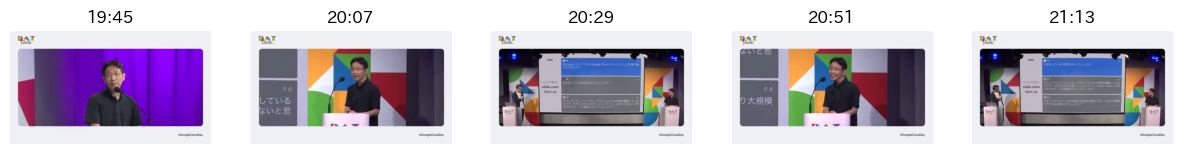

=====
このシーンでは、北瀬氏が参加者からの質問を読み上げ、中井氏がそれに答えています。質問は「プロンプトチューニングはモデルそのものをチューニングしているわけではないのか？」というもので、中井氏は「プロンプトチューニングはモデルそのものをいじっているわけではなく、あくまでもモデルに入力する内容をチューニングしているだけです。モデルそのものをいじっているわけではないので、気持ちとしてはチューニングやエンジニアリングという気持ちは分かりますが、機械学習の仕組みを知っている人間からすると、気持ち悪いという気持ちはあります。」と答えています。さらに、北瀬氏は「今後、モデルのサイズを圧縮する技術が発展しても、やはり大規模なモデルは必要なのか？」という質問を読み上げ、中井氏は「モデルを圧縮する技術はあくまでも圧縮する技術なので、圧縮する元になる大規模なモデルはやはり誰かが作る必要があります。それを1ユーザーが自分で作るという場面はあまりないと思いますが、やはり大規模な分散インフラを持っている企業が、まず大規模な新しいモデルをどんどん作っていく。そして、それを圧縮する技術を組み合わせることで、個人でも利用できるような、簡単に利用できる環境が整っていく。そんな流れは今後も続くのではないかと思います。」と答えています。


<Figure size 640x480 with 0 Axes>

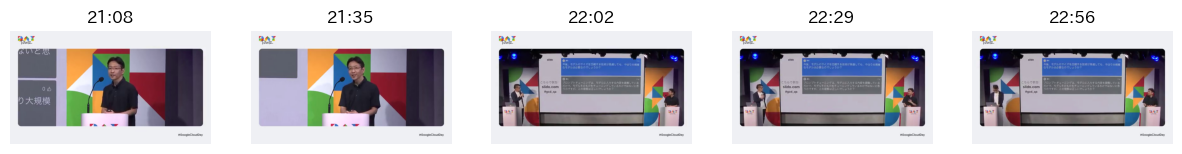

<Figure size 640x480 with 0 Axes>

In [37]:
show_thumbnails(load_json(result))

In [38]:
%%time
query = '発表者が大きく写っているシーン'
prompt = prompt_content_search.format(
    query, summary, important_scenes, visual_info, transcription, texts)
result = generate(prompt, model=model_flash)

```json
[
  {
    "Timestamp": "00:11-00:15",
    "Description": "このシーンでは、中井悦司氏がステージに立っており、背景にはGoogle CloudのロゴとDAY Tourのロゴが表示されています。中井悦司氏は、黒いポロシャツを着て、眼鏡をかけています。このシーンでは、中井悦司氏が大きく写っており、発表者であることが明確にわかります。",
    "Evidence": [
      "00:11-00:15, ステージ上で中井 悦司が演台の前に立っています。背景には、赤、青、黄、緑の図形を組み合わせたデザインと「Google Cloud」「DAY Tour」のロゴが配置されています。中井 悦司は黒いポロシャツを着て、眼鏡をかけています。"
    ]
  },
  {
    "Timestamp": "00:15-00:28",
    "Description": "このシーンでは、中井悦司氏が演台で話しており、背景にはGoogle CloudのロゴとDAY Tourのロゴが表示されています。中井悦司氏は、黒いポロシャツを着て、眼鏡をかけています。このシーンでは、中井悦司氏が大きく写っており、発表者であることが明確にわかります。",
    "Evidence": [
      "00:15-00:28, 中井 悦司が演台で話しています。背景には、赤、青、黄、緑の図形を組み合わせたデザインと「Google Cloud」「DAY Tour」のロゴが配置されています。中井 悦司は黒いポロシャツを着て、眼鏡をかけています。左下に「中井 悦司」「Google Cloud / ソリューションズ アーキテクト」と記され、右下に「#GoogleCloudDay」のハッシュタグが表示されています。"
    ]
  }
]
```CPU times: user 82.7 ms, sys: 8.81 ms, total: 91.5 ms
Wall time: 2.29 s


=====
このシーンでは、中井悦司氏がステージに立っており、背景にはGoogle CloudのロゴとDAY Tourのロゴが表示されています。中井悦司氏は、黒いポロシャツを着て、眼鏡をかけています。このシーンでは、中井悦司氏が大きく写っており、発表者であることが明確にわかります。


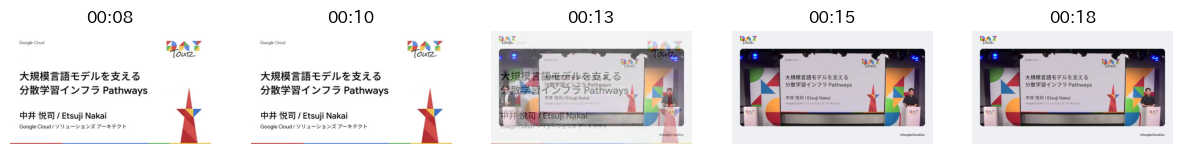

=====
このシーンでは、中井悦司氏が演台で話しており、背景にはGoogle CloudのロゴとDAY Tourのロゴが表示されています。中井悦司氏は、黒いポロシャツを着て、眼鏡をかけています。このシーンでは、中井悦司氏が大きく写っており、発表者であることが明確にわかります。


<Figure size 640x480 with 0 Axes>

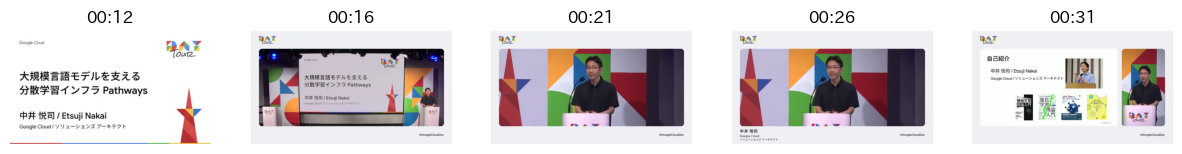

<Figure size 640x480 with 0 Axes>

In [39]:
show_thumbnails(load_json(result))

## 動画ベースの動画内検索

In [40]:
prompt_movie_content_search = '''\
You are a video content editor.
Find one to three scenes that matches the user query with timestamps.

[condition]
Try to identify names of characters.
The result should be based on the objective information in the movie itself.

[user query]
{}

[format instruction]
Output in Japanese. Output is a JSON list with "scene dict".
Each "scene dict" is a JSON dict with the following format:
{{
  "Timestamp": "<timestamp mm:ss-mm:ss>",
  "Description": "<Explain how this scene matches the query.>"
}}
'''

In [49]:
%%time
query = 'ニューラルスケーリングについて解説しているシーン'
prompt = prompt_movie_content_search.format(query)
prompt = [prompt] + prompt_reference
result = generate(prompt, model=model)

[
  {
    "Timestamp": "04:29-05:12",
    "Description": "中井さんが、機械学習モデル、ディープラーニングモデルのサイズが大きくなると性能が向上するというニューラルスケーリングについて解説しているシーンです。"
  }
]CPU times: user 93.5 ms, sys: 14.1 ms, total: 108 ms
Wall time: 32.7 s


=====
中井さんが、機械学習モデル、ディープラーニングモデルのサイズが大きくなると性能が向上するというニューラルスケーリングについて解説しているシーンです。


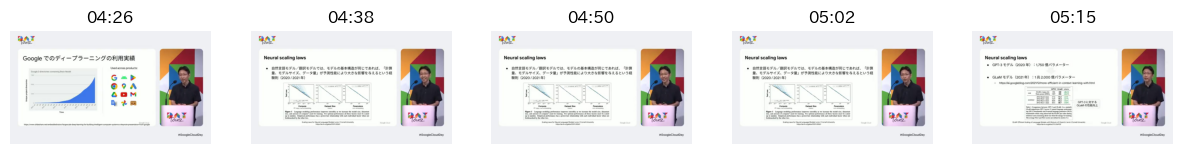

<Figure size 640x480 with 0 Axes>

In [50]:
show_thumbnails(load_json(result))

In [57]:
%%time
query = '視聴者からの質問に答えているシーン'
prompt = prompt_movie_content_search.format(query)
prompt = [prompt] + prompt_reference
result = generate(prompt, model=model)

[
  {
    "Timestamp": "18:24-19:13",
    "Description": "中井 悦司さんが視聴者からの質問「中井さんの勉強方法が知りたいです。どうやって情報収集や新しいものへの取り組みをされているのでしょうか？」に答えています。"
  },
  {
    "Timestamp": "19:16-20:20",
    "Description": "中井 悦司さんが視聴者からの質問「GKEでTPU Podを利用できるのでしょうか。」に答えています。"
  },
  {
    "Timestamp": "20:22-22:53",
    "Description": "中井 悦司さんが視聴者からの質問「今注目しているAI技術は何でしょうか？」「今後、モデルのサイズを圧縮する技術が発達しても、やはり大規模なモデルは必要なのでしょうか？」に答えています。"
  }
]CPU times: user 102 ms, sys: 41.7 ms, total: 144 ms
Wall time: 42.9 s


=====
中井 悦司さんが視聴者からの質問「中井さんの勉強方法が知りたいです。どうやって情報収集や新しいものへの取り組みをされているのでしょうか？」に答えています。


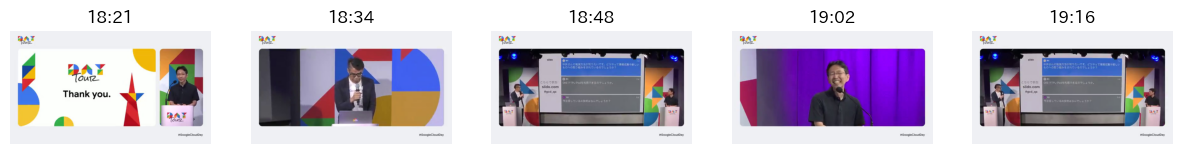

=====
中井 悦司さんが視聴者からの質問「GKEでTPU Podを利用できるのでしょうか。」に答えています。


<Figure size 640x480 with 0 Axes>

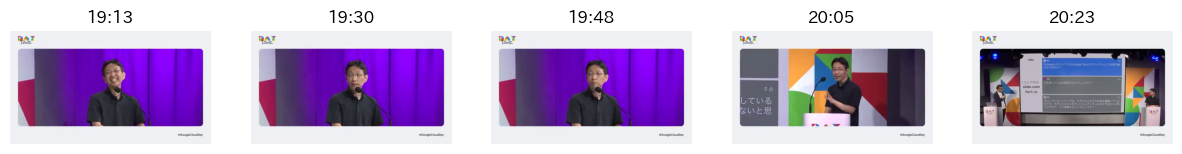

=====
中井 悦司さんが視聴者からの質問「今注目しているAI技術は何でしょうか？」「今後、モデルのサイズを圧縮する技術が発達しても、やはり大規模なモデルは必要なのでしょうか？」に答えています。


<Figure size 640x480 with 0 Axes>

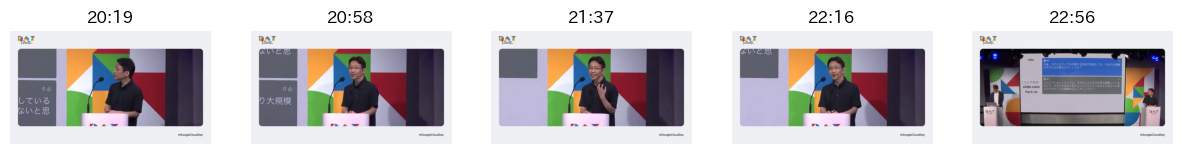

<Figure size 640x480 with 0 Axes>

In [58]:
show_thumbnails(load_json(result))

In [59]:
%%time
query = '発表者が大きく写っているシーン'
prompt = prompt_movie_content_search.format(query)
prompt = [prompt] + prompt_reference
result = generate(prompt, model=model)

[
  {
    "Timestamp": "00:12-00:33",
    "Description": "中井 悦司さんが壇上で大きく写っています。"
  },
  {
    "Timestamp": "00:33-03:17",
    "Description": "中井 悦司さんが壇上で大きく写っています。"
  },
  {
    "Timestamp": "03:17-08:02",
    "Description": "中井 悦司さんが壇上で大きく写っています。"
  },
  {
    "Timestamp": "08:02-12:44",
    "Description": "中井 悦司さんが壇上で大きく写っています。"
  },
  {
    "Timestamp": "12:44-17:43",
    "Description": "中井 悦司さんが壇上で大きく写っています。"
  },
  {
    "Timestamp": "17:43-18:23",
    "Description": "中井 悦司さんが壇上で大きく写っています。"
  }
]CPU times: user 81.2 ms, sys: 40.4 ms, total: 122 ms
Wall time: 35.7 s


=====
中井 悦司さんが壇上で大きく写っています。


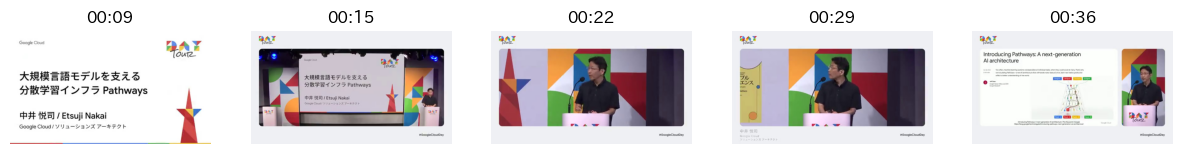

=====
中井 悦司さんが壇上で大きく写っています。


<Figure size 640x480 with 0 Axes>

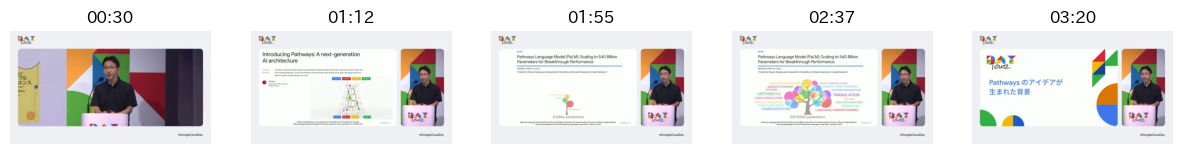

=====
中井 悦司さんが壇上で大きく写っています。


<Figure size 640x480 with 0 Axes>

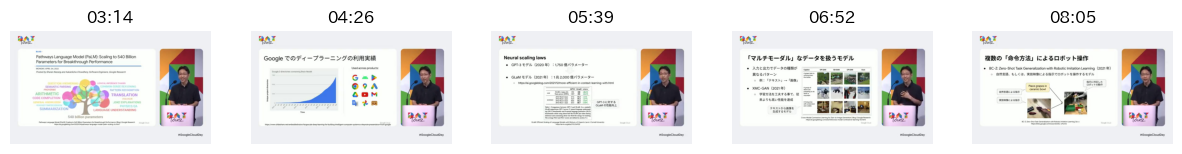

=====
中井 悦司さんが壇上で大きく写っています。


<Figure size 640x480 with 0 Axes>

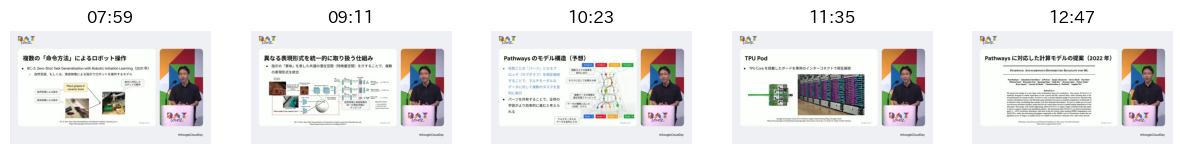

=====
中井 悦司さんが壇上で大きく写っています。


<Figure size 640x480 with 0 Axes>

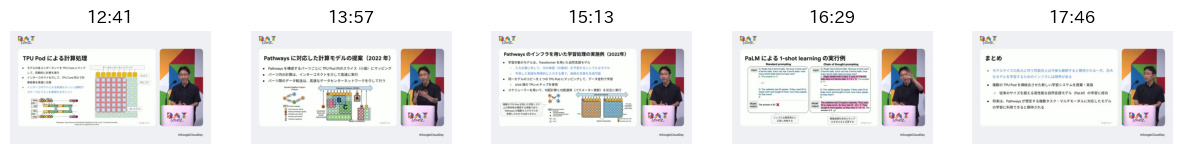

=====
中井 悦司さんが壇上で大きく写っています。


<Figure size 640x480 with 0 Axes>

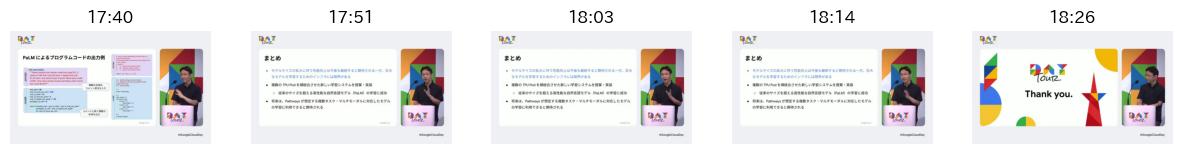

<Figure size 640x480 with 0 Axes>

In [60]:
show_thumbnails(load_json(result))

## 検索用メタテキストを保存

In [61]:
meta_text = '''\
[summary]
{}

[important scenes]
{}

[visual info]
{}

[transcription]
{}

[texts]
{}'''.format(summary, important_scenes, visual_info, transcription, texts)

metafile = f'{basename}.txt'
with open(metafile, 'w') as f:
    f.write(meta_text)

In [62]:
!gsutil cp "{metafile}" {BUCKET}/metadata/

Copying file://大規模言語モデルを支える分散学習インフラ Pathways.txt [Content-Type=text/plain]...
/ [1 files][ 90.1 KiB/ 90.1 KiB]                                                
Operation completed over 1 objects/90.1 KiB.                                     
